# ROB 498-011/599-011 Project 3: Pose Estimation - PoseCNN
Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Anthony OPIPARI, #12345678

**Your Answer:**   
Chitrangada Devulapalli, #56048432

# PoseCNN: A Classic end-to-end pose estimation network

In this exercise you will implement an **end-to-end** object pose estimator, based on [PoseCNN](https://arxiv.org/abs/1711.00199), which consists of two stages - feature extraction with a backbone network and pose estimation represented by instance segmentation, 3D translation estimation, and 3D rotation estimation.
We will train it to estimate the pose of a set of object classes and evaluate the estimation accuracy.

# Getting Started

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the following cell should print the filenames from the assignment:

```
["p3_helper.py", "rob599", "pose_cnn.py", "pose_estimation.ipynb"]
```

In [ ]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2024WN folder and put all the files under P3 folder, then "2024WN/P3"
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2024WN/P3'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "/content/drive/MyDrive/P3"
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['rob599', '__pycache__', '.ipynb_checkpoints', 'PROPS-Pose-Dataset.tar.gz', 'PROPS-Pose-Dataset', 'p3_helper.py', 'posecnn_model.pth', 'pose_cnn.py', 'pose_estimation.ipynb']


Next, we install a couple packages to help with processing and visualizing object models.

In [ ]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

%pip install trimesh
%pip install pyrender
%pip install pyquaternion

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.5/689.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.8/876.8 kB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745192 sha256=1958f5c7b7b211c7ad701ddf4a52379f53e4e570f54ac8dfd6ab9e925d8bc6b9
  Stored in directory: /root/.cache/pip/wheels/a1/3c/d2/1f9533f908d86176637521e533c6cdb2d4e48b59003b5c3f19
Successfully built PyOpenGL
  Attempting uninstall: PyOpenGL
    Found existing installation: PyOpenGL 3.1.7
    Uninstalling PyOpenGL-3.1.7:
      Successfully uninstalled PyOpenGL-3.1.7


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from pose_cnn.py!
Hello from p3_helper.py!
```

as well as the last edit time for the file `pose_cnn.py`.

In [ ]:
import os
import time

os.environ["TZ"] = "US/Eastern"
time.tzset()

from pose_cnn import hello_pose_cnn
from p3_helper import hello_helper


hello_pose_cnn()
hello_helper()

pose_cnn_path = os.path.join(GOOGLE_DRIVE_PATH, "pose_cnn.py")
pose_cnn_edit_time = time.ctime(
    os.path.getmtime(pose_cnn_path)
)
print("pose_cnn.py last edited on %s" % pose_cnn_edit_time)

Hello from pose_cnn.py!
Hello from P3_helper.py!
pose_cnn.py last edited on Sat Mar 16 12:03:15 2024


Load several useful packages that are used in this notebook:

In [ ]:
import os
import time

import matplotlib.pyplot as plt
import torch
import torchvision

%matplotlib inline

from p3_helper import *
from rob599 import reset_seed
from rob599.grad import rel_error

# for plotting
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 16
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [ ]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


## Load PROPS Pose Dataset
During the majority of our homework assignments so far, we have used the PROPS Classification or Detection datasets for image processing tasks.

In order to train and evaluate object pose estimation models, we need a dataset where each image is annotated with a *set* of *pose labels*, where each pose label gives the 3DoF position and 3DoF orientation of some object in the image.

We will use the [PROPS Pose](https://deeprob.org/datasets/props-pose/) dataset, which provides annotations of this form.
Our PROPS Detection dataset is much smaller than typical benchmarking pose estimation datasets, and thus easier to manage in an homework assignment.
PROPS comprises annotated bounding boxes for 10 object classes:
`["master_chef_can", "cracker_box", "sugar_box", "tomato_soup_can", "mustard_bottle", "tuna_fish_can", "gelatin_box", "potted_meat_can", "mug", "large_marker"]`.
The choice of these objects is inspired by the [YCB object and Model set](https://ieeexplore.ieee.org/document/7251504) commonly used in robotic perception models.

We create a [`PyTorch Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class
named `PROPSPoseDataset` in `rob599/PROPSPoseDataset.py` that will download the PROPS Pose dataset.

Run the following two cells to set a few config parameters and then download the train/val sets for the PROPS Pose dataset.

In [ ]:
import multiprocessing

# Set a few constants related to data loading.
NUM_CLASSES = 10
BATCH_SIZE = 4
NUM_WORKERS = multiprocessing.cpu_count()

In [ ]:
from rob599 import PROPSPoseDataset

# NOTE: Set `download=True` for the first time when you set up Google Drive folder.
# Turn it back to `False` later for faster execution in the future.
# If this hangs, download and place data in your drive manually.
train_dataset = PROPSPoseDataset(
    GOOGLE_DRIVE_PATH, "train",
    download=False  # True (for the first time)
)
val_dataset = PROPSPoseDataset(GOOGLE_DRIVE_PATH, "val")

print(f"Dataset sizes: train ({len(train_dataset)}), val ({len(val_dataset)})")

Dataset sizes: train (500), val (500)


This dataset will format each sample from the dataset as a dictionary containing the following keys:

 - 'rgb': a numpy float32 array of shape (3, 480, 640) scaled to range [0,1]
 - 'depth': a numpy int32 array of shape (1, 480, 640) in (mm)
 - 'objs_id': a numpy uint8 array of shape (10,) containing integer ids for visible objects (1-10) and invisible objects (0)
 - 'label': a numpy bool array of shape (11, 480, 640) containing instance segmentation for objects in the scene
 - 'bbx': a numpy float64 array of shape (10, 4) containing (x, y, w, h) coordinates of object bounding boxes
 - 'RTs': a numpy float64 array of shape (10, 3, 4) containing homogeneous transformation matrices per object into camera coordinate frame
 - 'centermaps': a numpy float64 array of shape (30, 480, 640) containing (dx, dy, z) coordinates to each object's centroid
 - 'centers': a numpy float64 array of shape (10, 2) containing (x, y) coordinates of object centroids projected to image plane

This dataset assumes that the upper left of the image is the origin point (0, 0).

### Visualize Dataset

Now let's visualize a few samples from our validation set to make sure the images and labels are loaded correctly. In this next cell, we'll use the `visualize_dataset` function from `rob599/utils.py` to view the RGB observation and labeled pose labels for three random samples.

In the below figure, the final column plots the centermaps for class 0, which corresponds to the master chef coffee can. This plot is included to give a sense of how the centermaps represent gradients towards the object's centroid.

In [ ]:
from rob599 import reset_seed, visualize_dataset

reset_seed(0)

grid_vis = visualize_dataset(val_dataset,alpha = 0.25)
plt.axis('off')
plt.imshow(grid_vis)
plt.show()

NameError: name 'val_dataset' is not defined

## Implementing PoseCNN

Now that we have our dataset loaded and ready to use, we'll begin implementing a variant of the [PoseCNN](https://arxiv.org/abs/1711.00199) network. This architecture is designed to take an RGB color image as input and produce a [6 degrees-of-freedom pose](https://en.wikipedia.org/wiki/Six_degrees_of_freedom) estimate for each instance of an object within the scene from which the image was taken. To do this, PoseCNN uses 5 operations within the architecture. First, a backbone convolutional feature extraction network is used to produce a tensor representing learned features from the input image. Second, the extracted features are processed by an embedding branch to reduce the spatial resolution and memory overhead for downstream layers. Third, an instance segmentation branch uses the embedded features to identify regions in the image corresponding to each object instance (regions of interest). Fourth, the translations for each object instance are estimated using a translation branch along with the embedded features. Finally, a rotation branch uses the embedded features to estimate a rotation, in the form of a [quaternion](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation), for each region of interest.

Thr architecture is shown in more detail from Figure 2 of the [PoseCNN paper](https://arxiv.org/abs/1711.00199):

![architecture](https://deeprob.org/assets/images/posecnn_arch.png)

Now, we will implement a variant of this architecture that performs each of the 5 operations using PyTorch and data from our `PROPSPoseDataset`. The remainder of the features for this project will be implemented in the `pose_cnn.py` file.

## Implementing the Backbone and Feature Extraction Branch

In the past project, you implemented a deep convolutional network from scratch. In this project, we'll use [torchvision's](https://pytorch.org/vision/stable/index.html) pretrained convolutional networks for our backbone convolutional feature extractor. Specifically, we'll use the [VGG16 model](https://arxiv.org/abs/1409.1556) as our feature extractor:

In [ ]:
import torchvision.models as models

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 84.4MB/s]


We can inspect the definition of this model by referring to the [model's source code within torchvision](https://pytorch.org/vision/main/_modules/torchvision/models/vgg.html). From this definition, we can see that the `vgg16.features` variable stores the feature extraction portion of VGG16 before average pooling. We'll use this pretrained VGG16 model for our PoseCNN model's pretrained extraction backbone. Print out the layers in `vgg16.features` by running the code cell below:

In [ ]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

Using this `vgg16` model as the `pretrained_network`, we implement PoseCNN's feature extraction branch for you in the `FeatureExtraction` class of `pose_cnn.py`. You should inspect this function to understand how the output `feature1` and `feature2` tensors are created. In addition, observe that we freeze the early layers of our pretrained network by setting the corresponding convolutional weights and bias to have `requires_grad=False`. Freezing these layers will speed up training and help reduce overfitting.

We can inspect the expected sizes of `feature1` and `feature2` by passing the `FeatureExtraction` dummy input:

In [ ]:
import torchvision.models as models
from pose_cnn import FeatureExtraction

# Based on PoseCNN section III.B, the output features should
# be 1/8 and 1/16 the input's spatial resolution with 512 channels
print('feature1 expected shape: (N, {}, {}, {})'.format(512, 480//8, 640//8))
print('feature2 expected shape: (N, {}, {}, {})'.format(512, 480//16, 640//16))
print()

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
feature_extractor = FeatureExtraction(pretrained_model=vgg16)

dummy_input = {'rgb': torch.zeros((2,3,480,640))}
feature1, feature2 = feature_extractor(dummy_input)

print('feature1 shape:', feature1.shape)
print('feature2 shape:', feature2.shape)

feature1 expected shape: (N, 512, 60, 80)
feature2 expected shape: (N, 512, 30, 40)



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 100MB/s]


feature1 shape: torch.Size([2, 512, 60, 80])
feature2 shape: torch.Size([2, 512, 30, 40])


Before moving on to the embedding and segmentation branch, take a moment to connect our `feature1` and `feature2` variables with the PoseCNN figure 2 shown earlier in the notebook. Understanding which arrows corresponds to `feature1` and `feature2` will make the remaining networks more comprehensible.

## Implementing Segmentation Branch

Now that we have our feature extractor setup, we'll implement the instnace segmentation branch. This branch should fuse information from the feature extractor (`feature1` and `feature2`) according to the architecture diagram of PoseCNN. Specifically, the network will pass both outputs from the feature extractor through a 1x1 convolution+ReLU layer followed by interpolation and an element wise addition. Next these intermediate features are interpolated back to the input image size followed by a final 1x1 convolution+ReLU layer to predict a probability for each class or background at each pixel. Follow the instructions in the `SegmentationBranch` class of `pose_cnn.py` to implement this branch.

In [ ]:
import torchvision.models as models
from rob599 import reset_seed
from pose_cnn import FeatureExtraction, SegmentationBranch

reset_seed(0)

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
feature_extractor = FeatureExtraction(pretrained_model=vgg16)
segmentation_branch = SegmentationBranch()

dummy_input = {'rgb': torch.zeros((2,3,480,640))}
feature1, feature2 = feature_extractor(dummy_input)
probability, segmentation, bbx = segmentation_branch(feature1, feature2)

print('probability expected shape: (B, 11, 480, 640)')
print('segmentation expected shape: (B, 480, 640)')
print('bbx expected shape: (N, 6) (where N is the number of rois extracted from the predicted segmentation)')
print()
print('probability shape:', probability.shape)
print('segmentation shape:', segmentation.shape)
print('bbx shape:', bbx.shape)

probability expected shape: (B, 11, 480, 640)
segmentation expected shape: (B, 480, 640)
bbx expected shape: (N, 6) (where N is the number of rois extracted from the predicted segmentation)

probability shape: torch.Size([2, 11, 480, 640])
segmentation shape: torch.Size([2, 480, 640])
bbx shape: torch.Size([10, 6])


### Adding Instance Segmentation Branch to PoseCNN

Now that we have our instance segmentation branch implemented, we can begin building up our `PoseCNN` class. In `pose_cnn.py` use the given `FeatureExtraction` class and your implemented `SegmentationBranch` to initialize the extraction and segmentation portion of PoseCNN. Next, implement the training and testing time forward pass of `PoseCNN` to perform only instance segmentation. We will come back and add rotation+translation branches once we are confident in our instance segmentation.

### Training PoseCNN to Perform Instance Segmentation

Once you've added code to initialize and perform the forward pass of PoseCNN for feature extraction and instance segmentation, we can attempt to train this part of PoseCNN by itself. The code in the following cell will initialize a PoseCNN model and begin training it on instance segmentation only. You should expect to see your training loss decrease to ~0.1 after training for 2 epochs.

  0%|          | 0/125 [00:00<?, ?it/s]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  2%|▏         | 2/125 [00:28<33:25, 16.31s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  2%|▏         | 3/125 [00:53<41:36, 20.46s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  3%|▎         | 4/125 [01:18<45:07, 22.38s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  4%|▍         | 5/125 [01:42<45:47, 22.89s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  5%|▍         | 6/125 [02:06<46:16, 23.33s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  6%|▌         | 7/125 [02:33<47:44, 24.27s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  6%|▋         | 8/125 [02:58<48:04, 24.65s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  7%|▋         | 9/125 [03:23<47:29, 24.57s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  8%|▊         | 10/125 [03:46<46:31, 24.27s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  9%|▉         | 11/125 [04:12<47:20, 24.92s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 10%|▉         | 12/125 [04:35<45:37, 24.23s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 10%|█         | 13/125 [04:58<44:15, 23.71s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 11%|█         | 14/125 [05:22<44:10, 23.88s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 12%|█▏        | 15/125 [05:47<44:12, 24.11s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 13%|█▎        | 16/125 [06:10<43:38, 24.02s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 14%|█▎        | 17/125 [06:33<42:12, 23.45s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 14%|█▍        | 18/125 [06:58<42:59, 24.11s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 15%|█▌        | 19/125 [07:20<41:37, 23.56s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 16%|█▌        | 20/125 [07:45<41:37, 23.79s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 17%|█▋        | 21/125 [08:08<40:54, 23.60s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 18%|█▊        | 22/125 [08:32<40:42, 23.71s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 18%|█▊        | 23/125 [08:56<40:41, 23.94s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 19%|█▉        | 24/125 [09:22<40:54, 24.31s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 20%|██        | 25/125 [09:46<40:45, 24.45s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 21%|██        | 26/125 [10:09<39:36, 24.00s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 22%|██▏       | 27/125 [10:32<38:40, 23.68s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 22%|██▏       | 28/125 [10:58<39:27, 24.40s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 23%|██▎       | 29/125 [11:23<39:00, 24.38s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 24%|██▍       | 30/125 [11:45<37:51, 23.91s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 25%|██▍       | 31/125 [12:09<37:22, 23.85s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 26%|██▌       | 32/125 [12:32<36:39, 23.65s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 26%|██▋       | 33/125 [12:55<35:39, 23.26s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 27%|██▋       | 34/125 [13:18<35:17, 23.27s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 28%|██▊       | 35/125 [13:42<35:11, 23.46s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 29%|██▉       | 36/125 [14:07<35:19, 23.82s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 30%|██▉       | 37/125 [14:33<36:02, 24.57s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 30%|███       | 38/125 [14:58<35:41, 24.62s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 31%|███       | 39/125 [15:22<35:01, 24.43s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 32%|███▏      | 40/125 [15:57<39:28, 27.86s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 33%|███▎      | 41/125 [16:21<37:08, 26.53s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 34%|███▎      | 42/125 [16:43<34:43, 25.10s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 34%|███▍      | 43/125 [17:06<33:45, 24.70s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 35%|███▌      | 44/125 [17:31<33:10, 24.58s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 36%|███▌      | 45/125 [17:55<32:33, 24.42s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 37%|███▋      | 46/125 [18:20<32:25, 24.62s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 38%|███▊      | 47/125 [18:43<31:16, 24.06s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 38%|███▊      | 48/125 [19:08<31:16, 24.37s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 39%|███▉      | 49/125 [19:33<31:21, 24.76s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 40%|████      | 50/125 [19:58<31:04, 24.87s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 41%|████      | 51/125 [20:23<30:32, 24.76s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 42%|████▏     | 52/125 [20:48<30:14, 24.86s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 42%|████▏     | 53/125 [21:12<29:34, 24.64s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 43%|████▎     | 54/125 [21:35<28:27, 24.05s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 44%|████▍     | 55/125 [21:58<27:38, 23.69s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 45%|████▍     | 56/125 [22:21<27:09, 23.62s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 46%|████▌     | 57/125 [22:48<27:49, 24.56s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 46%|████▋     | 58/125 [23:14<27:45, 24.86s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 47%|████▋     | 59/125 [23:38<27:15, 24.78s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 48%|████▊     | 60/125 [24:01<26:21, 24.33s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 49%|████▉     | 61/125 [24:25<25:46, 24.17s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 50%|████▉     | 62/125 [24:49<25:23, 24.19s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 50%|█████     | 63/125 [25:12<24:37, 23.83s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 51%|█████     | 64/125 [25:38<24:40, 24.28s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 52%|█████▏    | 65/125 [26:02<24:17, 24.29s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 53%|█████▎    | 66/125 [26:26<23:45, 24.16s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 54%|█████▎    | 67/125 [26:50<23:16, 24.07s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 54%|█████▍    | 68/125 [27:13<22:43, 23.93s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 55%|█████▌    | 69/125 [27:37<22:09, 23.74s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 56%|█████▌    | 70/125 [28:01<21:51, 23.84s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 57%|█████▋    | 71/125 [28:25<21:37, 24.03s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 58%|█████▊    | 72/125 [28:48<20:55, 23.69s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 58%|█████▊    | 73/125 [29:12<20:29, 23.65s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 59%|█████▉    | 74/125 [29:35<20:03, 23.59s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 60%|██████    | 75/125 [30:00<19:56, 23.93s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 61%|██████    | 76/125 [30:23<19:15, 23.57s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 62%|██████▏   | 77/125 [30:45<18:41, 23.37s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 62%|██████▏   | 78/125 [31:07<17:53, 22.84s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 63%|██████▎   | 79/125 [31:30<17:27, 22.77s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 64%|██████▍   | 80/125 [31:55<17:36, 23.48s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 65%|██████▍   | 81/125 [32:18<17:06, 23.33s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 66%|██████▌   | 82/125 [32:41<16:41, 23.29s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 66%|██████▋   | 83/125 [33:04<16:20, 23.34s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 67%|██████▋   | 84/125 [33:26<15:39, 22.92s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 68%|██████▊   | 85/125 [33:49<15:18, 22.95s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 69%|██████▉   | 86/125 [34:12<14:49, 22.81s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 70%|██████▉   | 87/125 [34:36<14:43, 23.26s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 70%|███████   | 88/125 [35:01<14:36, 23.69s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 71%|███████   | 89/125 [35:24<14:02, 23.39s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 72%|███████▏  | 90/125 [35:48<13:46, 23.60s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 73%|███████▎  | 91/125 [36:10<13:13, 23.34s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 74%|███████▎  | 92/125 [36:37<13:23, 24.34s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 74%|███████▍  | 93/125 [37:00<12:47, 23.99s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 75%|███████▌  | 94/125 [37:22<11:59, 23.22s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 76%|███████▌  | 95/125 [37:46<11:42, 23.43s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 77%|███████▋  | 96/125 [38:10<11:25, 23.63s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 78%|███████▊  | 97/125 [38:34<11:08, 23.88s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 78%|███████▊  | 98/125 [38:56<10:31, 23.39s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 79%|███████▉  | 99/125 [39:19<10:00, 23.08s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 80%|████████  | 100/125 [39:41<09:31, 22.84s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 81%|████████  | 101/125 [40:03<09:02, 22.62s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 82%|████████▏ | 102/125 [40:28<08:57, 23.36s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 82%|████████▏ | 103/125 [40:50<08:25, 22.98s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 83%|████████▎ | 104/125 [41:13<08:00, 22.90s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 84%|████████▍ | 105/125 [41:37<07:44, 23.23s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 85%|████████▍ | 106/125 [42:01<07:26, 23.48s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 86%|████████▌ | 107/125 [42:24<07:01, 23.43s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 86%|████████▋ | 108/125 [42:47<06:34, 23.20s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 87%|████████▋ | 109/125 [43:10<06:07, 22.97s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 88%|████████▊ | 110/125 [43:31<05:39, 22.64s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 89%|████████▉ | 111/125 [43:54<05:15, 22.57s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 90%|████████▉ | 112/125 [44:17<04:56, 22.81s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 90%|█████████ | 113/125 [44:42<04:40, 23.38s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 91%|█████████ | 114/125 [45:05<04:16, 23.28s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 92%|█████████▏| 115/125 [45:29<03:56, 23.65s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 93%|█████████▎| 116/125 [45:52<03:30, 23.39s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 94%|█████████▎| 117/125 [46:15<03:05, 23.25s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 94%|█████████▍| 118/125 [46:37<02:40, 22.98s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 95%|█████████▌| 119/125 [47:01<02:18, 23.05s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 96%|█████████▌| 120/125 [47:24<01:56, 23.21s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 97%|█████████▋| 121/125 [47:46<01:31, 22.77s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 98%|█████████▊| 122/125 [48:10<01:09, 23.04s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 98%|█████████▊| 123/125 [48:32<00:45, 22.85s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 99%|█████████▉| 124/125 [48:56<00:23, 23.08s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


100%|██████████| 125/125 [49:19<00:00, 23.68s/it]


dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])
Time 00h 49m 19s, Epoch 00, Training finished , with mean training loss 0.519892992079258


  1%|          | 1/125 [00:01<02:47,  1.35s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  2%|▏         | 2/125 [00:02<02:52,  1.40s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  2%|▏         | 3/125 [00:04<02:51,  1.41s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  3%|▎         | 4/125 [00:06<03:15,  1.62s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  4%|▍         | 5/125 [00:08<03:42,  1.85s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  5%|▍         | 6/125 [00:09<03:23,  1.71s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  6%|▌         | 7/125 [00:11<03:11,  1.62s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  6%|▋         | 8/125 [00:12<03:00,  1.54s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  7%|▋         | 9/125 [00:14<02:52,  1.49s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  8%|▊         | 10/125 [00:15<02:49,  1.47s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  9%|▉         | 11/125 [00:16<02:47,  1.47s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 10%|▉         | 12/125 [00:18<02:48,  1.49s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 10%|█         | 13/125 [00:20<03:01,  1.62s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 11%|█         | 14/125 [00:22<03:04,  1.66s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 12%|█▏        | 15/125 [00:23<02:54,  1.59s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 13%|█▎        | 16/125 [00:24<02:46,  1.53s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 14%|█▎        | 17/125 [00:26<02:40,  1.49s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 14%|█▍        | 18/125 [00:27<02:37,  1.47s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 15%|█▌        | 19/125 [00:29<02:33,  1.45s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 16%|█▌        | 20/125 [00:30<02:31,  1.45s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 17%|█▋        | 21/125 [00:32<02:39,  1.54s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 18%|█▊        | 22/125 [00:34<02:59,  1.75s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 18%|█▊        | 23/125 [00:36<02:49,  1.67s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 19%|█▉        | 24/125 [00:37<02:41,  1.60s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 20%|██        | 25/125 [00:38<02:35,  1.55s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 21%|██        | 26/125 [00:40<02:29,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 22%|██▏       | 27/125 [00:41<02:25,  1.48s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 22%|██▏       | 28/125 [00:43<02:24,  1.49s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 23%|██▎       | 29/125 [00:44<02:21,  1.48s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 24%|██▍       | 30/125 [00:46<02:35,  1.64s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 25%|██▍       | 31/125 [00:48<02:42,  1.73s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 26%|██▌       | 32/125 [00:50<02:33,  1.65s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 26%|██▋       | 33/125 [00:51<02:27,  1.60s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 27%|██▋       | 34/125 [00:53<02:20,  1.54s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 28%|██▊       | 35/125 [00:54<02:16,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 29%|██▉       | 36/125 [00:55<02:12,  1.49s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 30%|██▉       | 37/125 [00:57<02:10,  1.49s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 30%|███       | 38/125 [00:59<02:16,  1.56s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 31%|███       | 39/125 [01:01<02:36,  1.81s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 32%|███▏      | 40/125 [01:02<02:22,  1.68s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 33%|███▎      | 41/125 [01:04<02:18,  1.65s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 34%|███▎      | 42/125 [01:06<02:25,  1.76s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 34%|███▍      | 43/125 [01:08<02:23,  1.75s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 35%|███▌      | 44/125 [01:09<02:15,  1.67s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 36%|███▌      | 45/125 [01:11<02:08,  1.61s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 37%|███▋      | 46/125 [01:13<02:19,  1.77s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 38%|███▊      | 47/125 [01:15<02:23,  1.84s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 38%|███▊      | 48/125 [01:16<02:13,  1.73s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 39%|███▉      | 49/125 [01:18<02:05,  1.65s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 40%|████      | 50/125 [01:19<02:00,  1.60s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 41%|████      | 51/125 [01:21<01:55,  1.56s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 42%|████▏     | 52/125 [01:22<01:51,  1.52s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 42%|████▏     | 53/125 [01:23<01:45,  1.47s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 43%|████▎     | 54/125 [01:25<01:44,  1.47s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 44%|████▍     | 55/125 [01:27<01:58,  1.70s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 45%|████▍     | 56/125 [01:29<01:53,  1.64s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 46%|████▌     | 57/125 [01:30<01:49,  1.60s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 46%|████▋     | 58/125 [01:32<01:44,  1.56s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 47%|████▋     | 59/125 [01:33<01:40,  1.52s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 48%|████▊     | 60/125 [01:35<01:37,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 49%|████▉     | 61/125 [01:36<01:34,  1.47s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 50%|████▉     | 62/125 [01:37<01:31,  1.46s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 50%|█████     | 63/125 [01:40<01:42,  1.66s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 51%|█████     | 64/125 [01:42<01:47,  1.77s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 52%|█████▏    | 65/125 [01:43<01:39,  1.66s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 53%|█████▎    | 66/125 [01:44<01:34,  1.60s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 54%|█████▎    | 67/125 [01:46<01:30,  1.56s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 54%|█████▍    | 68/125 [01:47<01:27,  1.54s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 55%|█████▌    | 69/125 [01:49<01:24,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 56%|█████▌    | 70/125 [01:50<01:22,  1.50s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 57%|█████▋    | 71/125 [01:52<01:27,  1.61s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 58%|█████▊    | 72/125 [01:54<01:35,  1.80s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 58%|█████▊    | 73/125 [01:56<01:27,  1.68s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 59%|█████▉    | 74/125 [01:57<01:22,  1.61s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 60%|██████    | 75/125 [01:59<01:18,  1.57s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 61%|██████    | 76/125 [02:00<01:14,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 62%|██████▏   | 77/125 [02:02<01:11,  1.48s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 62%|██████▏   | 78/125 [02:03<01:09,  1.49s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 63%|██████▎   | 79/125 [02:05<01:09,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 64%|██████▍   | 80/125 [02:07<01:18,  1.75s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 65%|██████▍   | 81/125 [02:08<01:13,  1.67s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 66%|██████▌   | 82/125 [02:10<01:08,  1.59s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 66%|██████▋   | 83/125 [02:11<01:06,  1.58s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 67%|██████▋   | 84/125 [02:13<01:02,  1.52s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 68%|██████▊   | 85/125 [02:14<00:59,  1.50s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 69%|██████▉   | 86/125 [02:16<00:57,  1.48s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 70%|██████▉   | 87/125 [02:17<00:56,  1.49s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 70%|███████   | 88/125 [02:20<01:05,  1.76s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 71%|███████   | 89/125 [02:21<01:02,  1.74s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 72%|███████▏  | 90/125 [02:23<00:57,  1.65s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 73%|███████▎  | 91/125 [02:24<00:54,  1.59s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 74%|███████▎  | 92/125 [02:25<00:50,  1.52s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 74%|███████▍  | 93/125 [02:27<00:48,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 75%|███████▌  | 94/125 [02:28<00:46,  1.50s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 76%|███████▌  | 95/125 [02:30<00:44,  1.48s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 77%|███████▋  | 96/125 [02:32<00:44,  1.54s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 78%|███████▊  | 97/125 [02:34<00:49,  1.76s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 78%|███████▊  | 98/125 [02:35<00:44,  1.66s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 79%|███████▉  | 99/125 [02:37<00:41,  1.59s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 80%|████████  | 100/125 [02:38<00:37,  1.52s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 81%|████████  | 101/125 [02:39<00:36,  1.50s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 82%|████████▏ | 102/125 [02:41<00:34,  1.50s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 82%|████████▏ | 103/125 [02:42<00:32,  1.46s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 83%|████████▎ | 104/125 [02:44<00:30,  1.46s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 84%|████████▍ | 105/125 [02:46<00:33,  1.67s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 85%|████████▍ | 106/125 [02:48<00:33,  1.78s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 86%|████████▌ | 107/125 [02:49<00:30,  1.68s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 86%|████████▋ | 108/125 [02:51<00:27,  1.60s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 87%|████████▋ | 109/125 [02:52<00:25,  1.58s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 88%|████████▊ | 110/125 [02:54<00:22,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 89%|████████▉ | 111/125 [02:55<00:20,  1.48s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 90%|████████▉ | 112/125 [02:57<00:19,  1.46s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 90%|█████████ | 113/125 [02:59<00:19,  1.61s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 91%|█████████ | 114/125 [03:01<00:19,  1.79s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 92%|█████████▏| 115/125 [03:02<00:16,  1.69s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 93%|█████████▎| 116/125 [03:04<00:14,  1.64s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 94%|█████████▎| 117/125 [03:05<00:12,  1.59s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 94%|█████████▍| 118/125 [03:07<00:11,  1.68s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 95%|█████████▌| 119/125 [03:09<00:10,  1.72s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 96%|█████████▌| 120/125 [03:10<00:08,  1.65s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 97%|█████████▋| 121/125 [03:13<00:07,  1.80s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 98%|█████████▊| 122/125 [03:15<00:05,  1.89s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 98%|█████████▊| 123/125 [03:16<00:03,  1.75s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 99%|█████████▉| 124/125 [03:18<00:01,  1.68s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


100%|██████████| 125/125 [03:19<00:00,  1.60s/it]


dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])
Time 00h 52m 39s, Epoch 01, Training finished , with mean training loss 0.10837537407875061


  1%|          | 1/125 [00:01<03:01,  1.46s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  2%|▏         | 2/125 [00:02<02:57,  1.44s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  2%|▏         | 3/125 [00:04<02:56,  1.45s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  3%|▎         | 4/125 [00:06<03:08,  1.56s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  4%|▍         | 5/125 [00:08<03:26,  1.72s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  5%|▍         | 6/125 [00:09<03:16,  1.65s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  6%|▌         | 7/125 [00:11<03:06,  1.58s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  6%|▋         | 8/125 [00:12<02:58,  1.53s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  7%|▋         | 9/125 [00:13<02:53,  1.50s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  8%|▊         | 10/125 [00:15<02:49,  1.48s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


  9%|▉         | 11/125 [00:16<02:47,  1.47s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 10%|▉         | 12/125 [00:18<02:46,  1.48s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 10%|█         | 13/125 [00:20<03:00,  1.61s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 11%|█         | 14/125 [00:22<03:11,  1.72s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 12%|█▏        | 15/125 [00:23<03:01,  1.65s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 13%|█▎        | 16/125 [00:25<02:52,  1.58s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 14%|█▎        | 17/125 [00:26<02:44,  1.52s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 14%|█▍        | 18/125 [00:27<02:38,  1.48s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 15%|█▌        | 19/125 [00:29<02:37,  1.49s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 16%|█▌        | 20/125 [00:30<02:35,  1.48s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 17%|█▋        | 21/125 [00:32<02:37,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 18%|█▊        | 22/125 [00:34<02:50,  1.66s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 18%|█▊        | 23/125 [00:36<02:49,  1.66s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 19%|█▉        | 24/125 [00:37<02:41,  1.60s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 20%|██        | 25/125 [00:38<02:35,  1.56s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 21%|██        | 26/125 [00:40<02:31,  1.53s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 22%|██▏       | 27/125 [00:41<02:26,  1.50s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 22%|██▏       | 28/125 [00:43<02:24,  1.49s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 23%|██▎       | 29/125 [00:44<02:21,  1.47s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 24%|██▍       | 30/125 [00:47<02:42,  1.71s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 25%|██▍       | 31/125 [00:48<02:47,  1.78s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 26%|██▌       | 32/125 [00:50<02:38,  1.71s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 26%|██▋       | 33/125 [00:51<02:28,  1.61s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 27%|██▋       | 34/125 [00:53<02:24,  1.59s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 28%|██▊       | 35/125 [00:54<02:18,  1.54s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 29%|██▉       | 36/125 [00:56<02:14,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 30%|██▉       | 37/125 [00:57<02:09,  1.48s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 30%|███       | 38/125 [00:59<02:21,  1.62s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 31%|███       | 39/125 [01:01<02:36,  1.82s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 32%|███▏      | 40/125 [01:03<02:23,  1.69s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 33%|███▎      | 41/125 [01:04<02:15,  1.61s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 34%|███▎      | 42/125 [01:06<02:06,  1.53s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 34%|███▍      | 43/125 [01:07<02:02,  1.50s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 35%|███▌      | 44/125 [01:08<01:59,  1.48s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 36%|███▌      | 45/125 [01:10<01:56,  1.46s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 37%|███▋      | 46/125 [01:11<01:55,  1.47s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 38%|███▊      | 47/125 [01:14<02:13,  1.72s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 38%|███▊      | 48/125 [01:15<02:11,  1.71s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 39%|███▉      | 49/125 [01:17<02:03,  1.62s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 40%|████      | 50/125 [01:18<01:57,  1.57s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 41%|████      | 51/125 [01:20<01:52,  1.53s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 42%|████▏     | 52/125 [01:21<01:48,  1.49s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 42%|████▏     | 53/125 [01:22<01:46,  1.47s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 43%|████▎     | 54/125 [01:24<01:43,  1.46s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 44%|████▍     | 55/125 [01:26<01:50,  1.58s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 45%|████▍     | 56/125 [01:28<02:04,  1.80s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 46%|████▌     | 57/125 [01:30<01:56,  1.71s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 46%|████▋     | 58/125 [01:31<01:51,  1.67s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 47%|████▋     | 59/125 [01:33<01:44,  1.59s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 48%|████▊     | 60/125 [01:34<01:40,  1.55s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 49%|████▉     | 61/125 [01:35<01:36,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 50%|████▉     | 62/125 [01:37<01:33,  1.49s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 50%|█████     | 63/125 [01:39<01:36,  1.55s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 51%|█████     | 64/125 [01:41<01:46,  1.74s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 52%|█████▏    | 65/125 [01:42<01:38,  1.64s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 53%|█████▎    | 66/125 [01:44<01:32,  1.57s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 54%|█████▎    | 67/125 [01:45<01:28,  1.53s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 54%|█████▍    | 68/125 [01:47<01:28,  1.55s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 55%|█████▌    | 69/125 [01:48<01:24,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 56%|█████▌    | 70/125 [01:50<01:36,  1.76s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 57%|█████▋    | 71/125 [01:53<01:43,  1.92s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 58%|█████▊    | 72/125 [01:55<01:44,  1.98s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 58%|█████▊    | 73/125 [01:56<01:34,  1.81s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 59%|█████▉    | 74/125 [01:58<01:26,  1.70s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 60%|██████    | 75/125 [01:59<01:21,  1.63s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 61%|██████    | 76/125 [02:01<01:16,  1.57s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 62%|██████▏   | 77/125 [02:02<01:14,  1.54s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 62%|██████▏   | 78/125 [02:03<01:10,  1.50s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 63%|██████▎   | 79/125 [02:05<01:11,  1.55s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 64%|██████▍   | 80/125 [02:07<01:17,  1.73s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 65%|██████▍   | 81/125 [02:09<01:12,  1.64s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 66%|██████▌   | 82/125 [02:10<01:08,  1.59s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 66%|██████▋   | 83/125 [02:12<01:05,  1.56s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 67%|██████▋   | 84/125 [02:13<01:01,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 68%|██████▊   | 85/125 [02:14<01:00,  1.50s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 69%|██████▉   | 86/125 [02:16<00:57,  1.47s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 70%|██████▉   | 87/125 [02:17<00:56,  1.49s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 70%|███████   | 88/125 [02:19<01:00,  1.64s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 71%|███████   | 89/125 [02:21<01:01,  1.70s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 72%|███████▏  | 90/125 [02:23<00:56,  1.62s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 73%|███████▎  | 91/125 [02:24<00:53,  1.58s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 74%|███████▎  | 92/125 [02:26<00:51,  1.56s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 74%|███████▍  | 93/125 [02:27<00:49,  1.54s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 75%|███████▌  | 94/125 [02:29<00:46,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 76%|███████▌  | 95/125 [02:30<00:44,  1.47s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 77%|███████▋  | 96/125 [02:32<00:45,  1.57s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 78%|███████▊  | 97/125 [02:34<00:49,  1.77s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 78%|███████▊  | 98/125 [02:36<00:45,  1.69s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 79%|███████▉  | 99/125 [02:37<00:42,  1.63s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 80%|████████  | 100/125 [02:38<00:39,  1.57s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 81%|████████  | 101/125 [02:40<00:37,  1.55s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 82%|████████▏ | 102/125 [02:41<00:34,  1.52s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 82%|████████▏ | 103/125 [02:43<00:32,  1.49s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 83%|████████▎ | 104/125 [02:44<00:31,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 84%|████████▍ | 105/125 [02:47<00:34,  1.72s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 85%|████████▍ | 106/125 [02:48<00:33,  1.74s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 86%|████████▌ | 107/125 [02:50<00:29,  1.64s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 86%|████████▋ | 108/125 [02:51<00:27,  1.61s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 87%|████████▋ | 109/125 [02:53<00:24,  1.56s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 88%|████████▊ | 110/125 [02:54<00:22,  1.53s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 89%|████████▉ | 111/125 [02:56<00:21,  1.52s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 90%|████████▉ | 112/125 [02:57<00:19,  1.51s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 90%|█████████ | 113/125 [02:59<00:20,  1.74s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 91%|█████████ | 114/125 [03:01<00:19,  1.79s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 92%|█████████▏| 115/125 [03:03<00:16,  1.70s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 93%|█████████▎| 116/125 [03:04<00:14,  1.63s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 94%|█████████▎| 117/125 [03:06<00:12,  1.57s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 94%|█████████▍| 118/125 [03:07<00:10,  1.53s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 95%|█████████▌| 119/125 [03:09<00:09,  1.52s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 96%|█████████▌| 120/125 [03:10<00:07,  1.53s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 97%|█████████▋| 121/125 [03:12<00:06,  1.62s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 98%|█████████▊| 122/125 [03:14<00:05,  1.75s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 98%|█████████▊| 123/125 [03:16<00:03,  1.66s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


 99%|█████████▉| 124/125 [03:17<00:01,  1.62s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])


100%|██████████| 125/125 [03:19<00:00,  1.59s/it]

dict_keys(['rgb', 'depth', 'objs_id', 'label', 'bbx', 'RTs', 'centermaps', 'centers'])
Time 00h 55m 58s, Epoch 02, Training finished , with mean training loss 0.08972584092617035


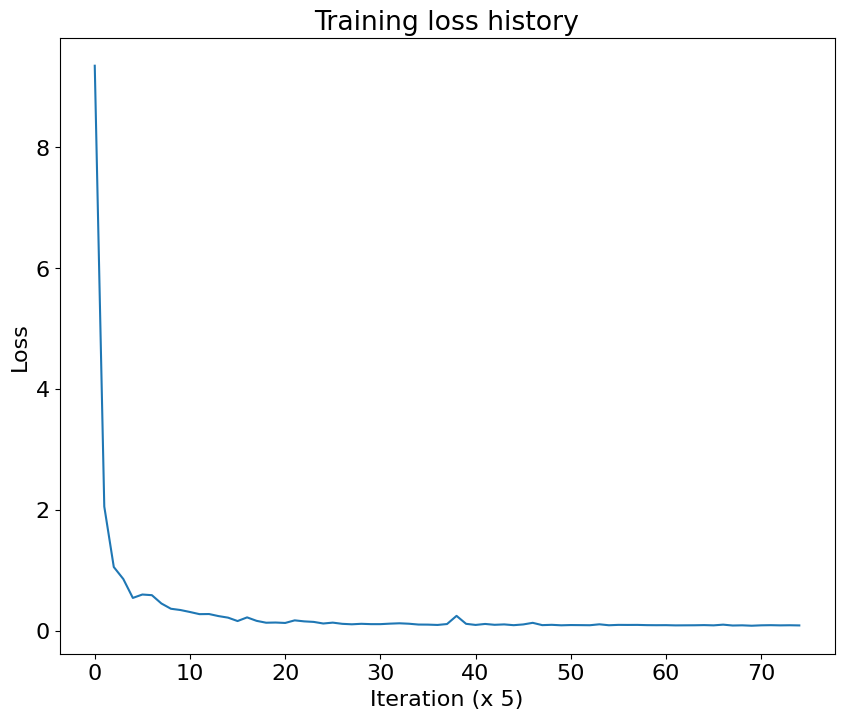

In [ ]:
import time
from torch.utils.data import DataLoader
import torchvision.models as models

from rob599 import reset_seed
from pose_cnn import PoseCNN
from tqdm import tqdm

reset_seed(0)

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).to(DEVICE)
posecnn_model = PoseCNN(pretrained_backbone = vgg16,
                       models_pcd = torch.tensor(train_dataset.models_pcd).to(DEVICE, dtype=torch.float32),
                       cam_intrinsic = train_dataset.cam_intrinsic).to(DEVICE)

dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(posecnn_model.parameters(), lr=0.001,
                                 betas=(0.9, 0.999))

posecnn_model.train()

loss_history = []
log_period = 5
_iter = 0

st_time = time.time()
for epoch in range(3):
    train_loss = []
    for batch in tqdm(dataloader):
        for item in batch:
            batch[item] = batch[item].to(DEVICE)
        loss_dict = posecnn_model(batch)
        optimizer.zero_grad()
        total_loss = loss_dict["loss_segmentation"]
        total_loss.backward()
        optimizer.step()
        train_loss.append(total_loss.item())

        if _iter % log_period == 0:
            loss_history.append(total_loss.item())
        _iter += 1

    print('Time {0}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)) + \
                                  ', ' + 'Epoch %02d' % epoch + ', ' + 'Training finished' + f' , with mean training loss {np.array(train_loss).mean()}'))

plt.title("Training loss history")
plt.xlabel(f"Iteration (x {log_period})")
plt.ylabel("Loss")
plt.plot(loss_history)
plt.show()

### Inference for Instance Segmentation

Now that we have our segmentation network trained, we can qualitatively evaluate the segmentation results. The following notebook cell will visualize output segmentations on a sample from the validation set.

In [ ]:
from torchvision.utils import make_grid
reset_seed(0)

num_samples = 3
posecnn_model.eval()

plt.text(300, -40, 'RGB', ha="center")
plt.text(950, -40, 'True\nSegmentation', ha="center")
plt.text(1600, -40, 'Predicted\nSegmentation', ha="center")

samples = []
for sample_i in range(num_samples):
    sample_idx = random.randint(0,len(val_dataset)-1)
    sample = val_dataset[sample_idx]

    rgb = torch.tensor(sample['rgb'][None, :]).to(DEVICE)
    _, prediction = posecnn_model({'rgb': rgb})
    prediction = prediction.cpu().numpy().astype(np.float64)
    prediction /= prediction.max()
    prediction = (np.tile(prediction, (3, 1, 1)) * 255).astype(np.uint8)
    rgb = (sample['rgb'].transpose(1, 2, 0) * 255).astype(np.uint8)
    depth = ((np.tile(sample['depth'], (3, 1, 1)) / sample['depth'].max()) * 255).astype(np.uint8)
    segmentation = (sample['label']*np.arange(11).reshape((11,1,1))).sum(0,keepdims=True).astype(np.float64)
    segmentation /= segmentation.max()
    segmentation = (np.tile(segmentation, (3, 1, 1)) * 255).astype(np.uint8)

    samples.append(torch.tensor(rgb.transpose(2, 0, 1)))
    samples.append(torch.tensor(segmentation))
    samples.append(torch.tensor(prediction))

img = make_grid(samples, nrow=3).permute(1, 2, 0)

plt.axis('off')
plt.imshow(img)
plt.show()

NameError: name 'posecnn_model' is not defined

Before moving on, visually inspect the segmentation results above to ensure your forward functions and loss calculations are setup correctly.

## Implementing the Translation Branch

Now that we have our feature extractor and instance segmentation working, we'll implement the rotation and translation branches of PoseCNN. We suggest starting with the translation branch, which follows a similar embedding structure as was used for instance segmentation. Based on the architecture described in the paper, implement your translation network in the `TranslationBranch` class of `pose_cnn.py`.

Once you have implemented `TranslationBranch`, the following notebook cell can be used to verify the shape of your output.

In [ ]:
import torchvision.models as models
from rob599 import reset_seed
from pose_cnn import FeatureExtraction, TranslationBranch

reset_seed(0)

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
feature_extractor = FeatureExtraction(pretrained_model=vgg16)
translation_branch = TranslationBranch()

dummy_input = {'rgb': torch.zeros((2,3,480,640))}
feature1, feature2 = feature_extractor(dummy_input)
translation = translation_branch(feature1, feature2)

print('translation expected shape: (2, 30, 480, 640)')
print()
print('translation shape:', translation.shape)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 82.0MB/s]


translation expected shape: (2, 30, 480, 640)

translation shape: torch.Size([2, 30, 480, 640])


## Implementing the Rotation Branch

Now you can implement the final module of PoseCNN: the rotation branch. This portion of PoseCNN will be reminiscient of fasterRCNN in that we will predict a quaternion for each possible class at each region of interest detected by our preceeding segmentation branch. To do this, we'll need to use ROIPooling for feature extraction. Since you implemented ROIPooling in the last project, feel free to use the [ROIPool](https://pytorch.org/vision/main/generated/torchvision.ops.RoIPool.html) implemented by `torchvision.ops` for this project.

Once you have implemented `RotationBranch`, the following notebook cell can be used to verify the shape of your output.

In [ ]:
import torchvision.models as models
from rob599 import reset_seed
from pose_cnn import FeatureExtraction, RotationBranch

reset_seed(0)

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
feature_extractor = FeatureExtraction(pretrained_model=vgg16)
rotation_branch = RotationBranch()

dummy_input = {'rgb': torch.zeros((2,3,480,640))}
dummy_bbx = torch.zeros((10,5)) # N = 10
feature1, feature2 = feature_extractor(dummy_input)
quaternion = rotation_branch(feature1, feature2, dummy_bbx)

print('quaternion expected shape: (N, 40)')
print()
print('quaternion shape:', quaternion.shape)

quaternion expected shape: (N, 40)

quaternion shape: torch.Size([10, 40])


## Hough Voting Layer

One important piece of the PoseCNN architecture for inference time that we haven't implemented yet is a Hough voting layer. As described in the text, and illustrated below, a Hough voting layer is used during inference time to extract a single centroid prediction from the translation maps produced by `TranslationBranch` and the segments produced by `SegmentationBranch`. Due to the timing constraints of our semester, we have implemented this Hough voting layer for you in `P3_helper.py` as the `HoughVoting` function. We recommend you use our provided `HoughVoting` function after reading through its implementation to understand how it works

![hough](https://deeprob.org/assets/images/posecnn_hough.png)

We also recommend reading through other given helper functions in `p3_helper.py` and the class definition of `PoseCNN` in `pose_cnn.py`. **Some of these utilities will be helpful for completing your PoseCNN implementation.**

## Putting it all together: PoseCNN

We now have all the modules needed to make up our PoseCNN architecture. In the `PoseCNN` class of `pose_cnn.py`, add the translation and rotation branches to the initialization and forward functions. During training, your PoseCNN model should output a `loss_dict` variable with loss values for segmentation, translation and rotation branches stored respectively with keys of `"loss_segmentation"`, `"loss_centermap"`, and `"loss_R"`. The segmentation loss should be calculated using `p3_helper.loss_cross_entropy`, the centroid loss should be calculated using l1Loss, and the rotation loss should be calculated using the provided helper in `p3_helper.loss_Rotation`. During inference, your model should output a dictionary of predicted poses (i.e. see `PoseCNN.generate_pose` for a formatting utility) in `output_dict` and the predicted segmentation map (post processed probabilities) in `segmentation`.

After this, you will be ready to train your PoseCNN model with all three losses:

[Iter 0][loss: 12.779][loss_segmentation: 9.123][loss_centermap: 3.656][loss_R: 0.000]
[Iter 5][loss: 2.842][loss_segmentation: 1.548][loss_centermap: 1.294][loss_R: 0.000]
[Iter 10][loss: 2.106][loss_segmentation: 1.332][loss_centermap: 0.774][loss_R: 0.000]
[Iter 15][loss: 1.698][loss_segmentation: 0.973][loss_centermap: 0.725][loss_R: 0.000]
[Iter 20][loss: 1.538][loss_segmentation: 0.914][loss_centermap: 0.624][loss_R: 0.000]
[Iter 25][loss: 1.403][loss_segmentation: 0.809][loss_centermap: 0.594][loss_R: 0.000]
[Iter 30][loss: 1.340][loss_segmentation: 0.733][loss_centermap: 0.607][loss_R: 0.000]
[Iter 35][loss: 1.339][loss_segmentation: 0.735][loss_centermap: 0.604][loss_R: 0.000]
[Iter 40][loss: 1.165][loss_segmentation: 0.619][loss_centermap: 0.545][loss_R: 0.000]
[Iter 45][loss: 1.078][loss_segmentation: 0.526][loss_centermap: 0.551][loss_R: 0.000]
[Iter 50][loss: 1.090][loss_segmentation: 0.492][loss_centermap: 0.527][loss_R: 0.070]
[Iter 55][loss: 0.997][loss_segmentation: 0.

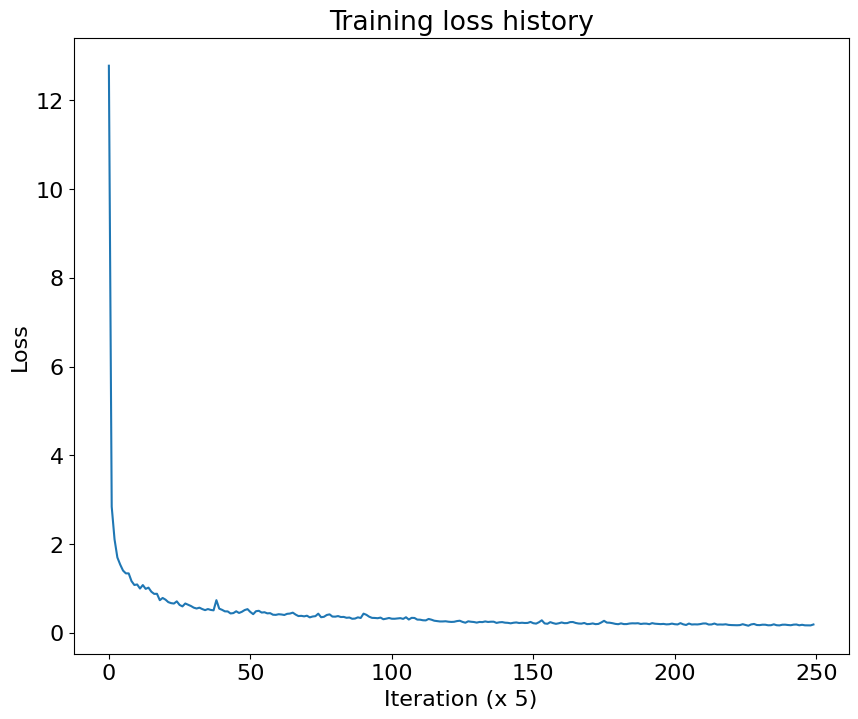

In [ ]:
import os
import time
import torch
from torch.utils.data import DataLoader
import torchvision.models as models

import rob599
from pose_cnn import PoseCNN


rob599.reset_seed(0)

dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
posecnn_model = PoseCNN(pretrained_backbone = vgg16,
                models_pcd = torch.tensor(train_dataset.models_pcd).to(DEVICE, dtype=torch.float32),
                cam_intrinsic = train_dataset.cam_intrinsic).to(DEVICE)
posecnn_model.train()

optimizer = torch.optim.Adam(posecnn_model.parameters(), lr=0.001,
                            betas=(0.9, 0.999))


loss_history = []
log_period = 5
_iter = 0


st_time = time.time()
for epoch in range(10):
    train_loss = []
    dataloader.dataset.dataset_type = 'train'
    for batch in dataloader:
        for item in batch:
            batch[item] = batch[item].to(DEVICE)
        loss_dict = posecnn_model(batch)
        optimizer.zero_grad()
        total_loss = 0
        for loss in loss_dict:
            total_loss += loss_dict[loss]
        total_loss.backward()
        optimizer.step()
        train_loss.append(total_loss.item())

        if _iter % log_period == 0:
            loss_str = f"[Iter {_iter}][loss: {total_loss:.3f}]"
            for key, value in loss_dict.items():
                loss_str += f"[{key}: {value:.3f}]"

            print(loss_str)
            loss_history.append(total_loss.item())
        _iter += 1

    print('Time {0}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)) + \
                                  ', ' + 'Epoch %02d' % epoch + ', ' + 'Training finished' + f' , with mean training loss {np.array(train_loss).mean()}'))

torch.save(posecnn_model.state_dict(), os.path.join(GOOGLE_DRIVE_PATH, "posecnn_model.pth"))

plt.title("Training loss history")
plt.xlabel(f"Iteration (x {log_period})")
plt.ylabel("Loss")
plt.plot(loss_history)
plt.show()

### Inference

Visualize a few outputs from the full trained model. These could be improved if we used a larger model, trained for greater duration, and if we used ICP with depth data to refine the final estimates.

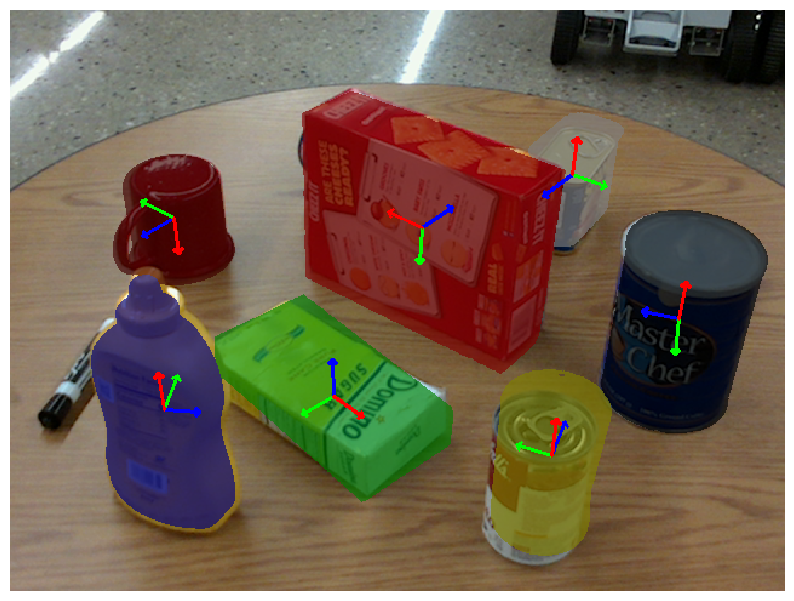

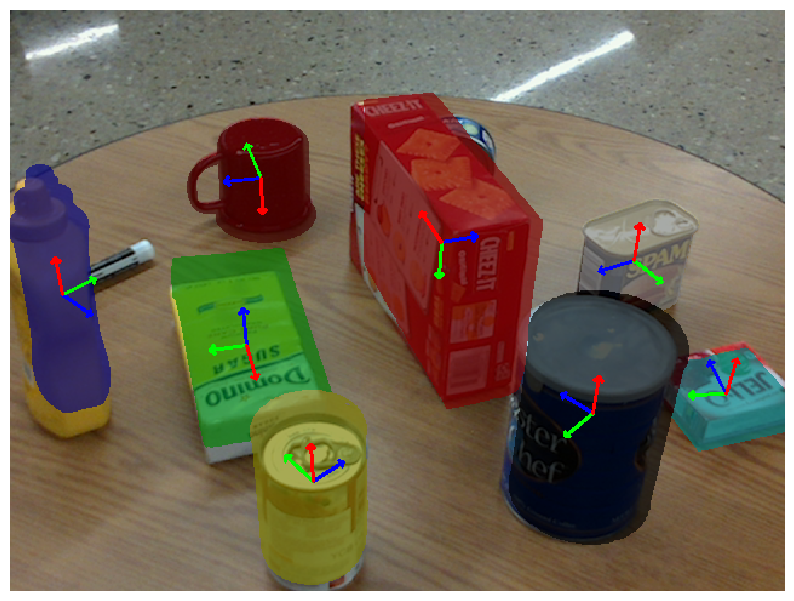

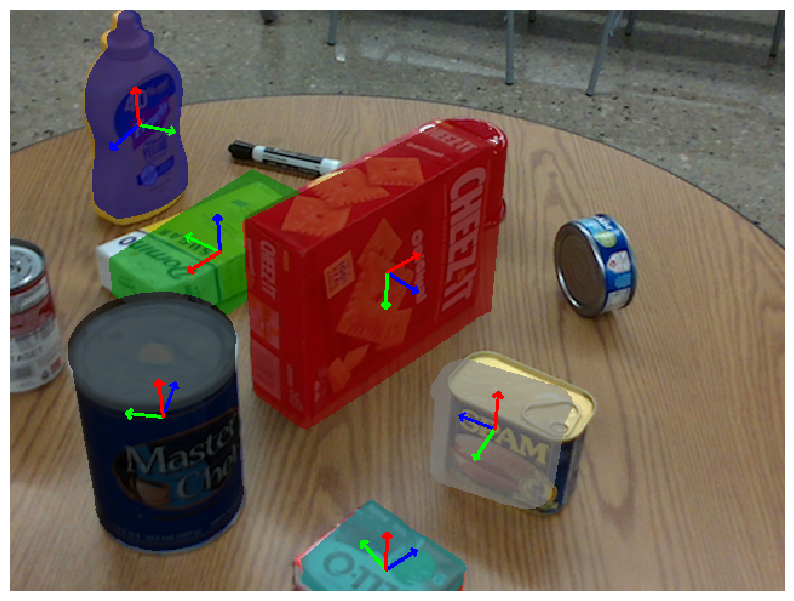

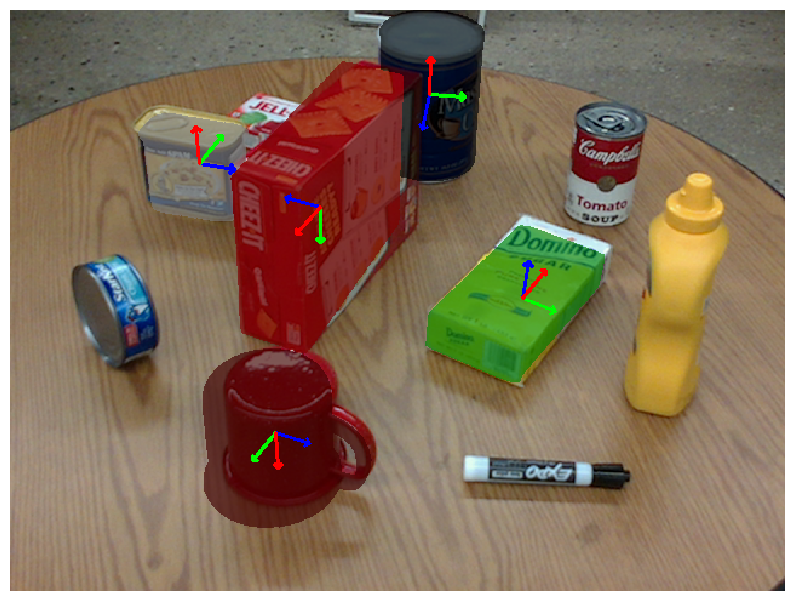

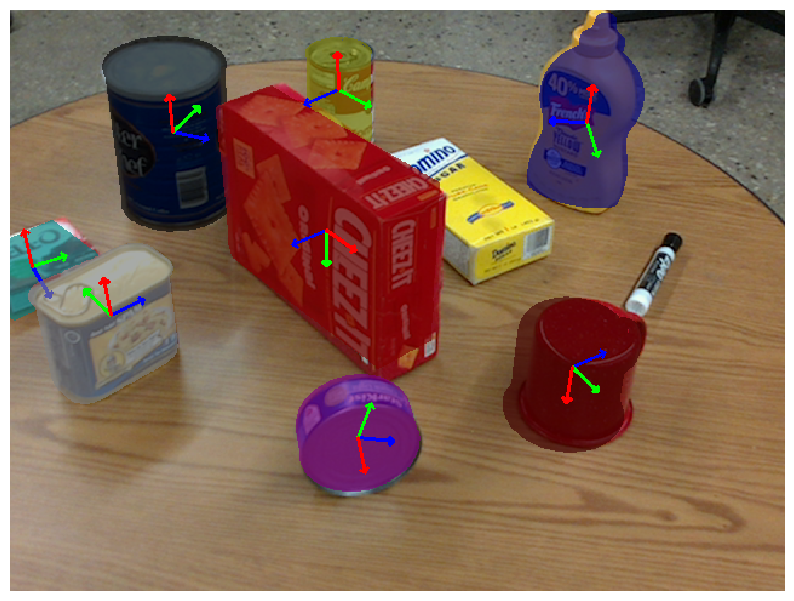

In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision.models as models

import rob599
from pose_cnn import PoseCNN, eval

rob599.reset_seed(0)

dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
posecnn_model = PoseCNN(pretrained_backbone = vgg16,
                models_pcd = torch.tensor(val_dataset.models_pcd).to(DEVICE, dtype=torch.float32),
                cam_intrinsic = val_dataset.cam_intrinsic).to(DEVICE)
posecnn_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, "posecnn_model.pth")))

num_samples = 5
for i in range(num_samples):
    out = eval(posecnn_model, dataloader, DEVICE)

    plt.axis('off')
    plt.imshow(out)
    plt.show()

Finally, let's measure the quantitative accuracy of our trained model using the 5°5cm metric. That is, we'll count how many visible objects our model was able to predict correctly, where a correct prediction is defined as one with a rotation error of less than 5° and a translation error of less than 5cm.

The instructor's model, trained with the hyperparameters above achieves 29.3%.

In [ ]:
import math
import torch
from torch.utils.data import DataLoader
import torchvision.models as models

import pyquaternion
from tqdm import tqdm

import rob599
from pose_cnn import PoseCNN

rob599.reset_seed(0)

dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)

posecnn_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, "posecnn_model.pth")))
posecnn_model.eval()


T_thresh = 5 # cm
R_thresh = 5 # deg

total =0
correct = 0
for batch in tqdm(dataloader):
    for item in batch:
        batch[item] = batch[item].to(DEVICE)
    pose_dict, segmentation = posecnn_model(batch)
    for bidx in range(BATCH_SIZE):
        objs_visib = batch['objs_id'][bidx].cpu().tolist()
        objs_preds = sorted(list(pose_dict[bidx].keys()))
        for objidx, objs_id in enumerate(objs_visib):
            if objs_id==0:
                continue

            total += 1
            if objs_id not in objs_preds:
                continue
            RT_pred = pose_dict[bidx][objs_id]
            RT_true = batch['RTs'][bidx][objidx].cpu().numpy()

            # Translation error
            T_pred = RT_pred[:3,3]
            T_true = RT_true[:3,3]
            T_err = 100*np.linalg.norm(T_pred-T_true) # error in cm

            # Rotation error
            R_true = pyquaternion.Quaternion(matrix=RT_true[:3,:3],atol=1e-6)
            R_pred = pyquaternion.Quaternion(matrix=RT_pred[:3,:3],atol=1e-6)

            R_rel = R_pred * R_true.conjugate
            R_err = math.degrees(R_rel.angle)

            if T_err<T_thresh and R_err<R_thresh:
                correct+=1

print("Accuracy at 5°5cm:",correct/total)

100%|██████████| 125/125 [1:21:45<00:00, 39.24s/it]

Accuracy at 5°5cm: 0.36824877250409166


# Submit Your Work
After completing this notebook, run the following cell to create a `.zip` file for you to download and turn in.

**Please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell:**

In [ ]:
from rob599.submit import make_p3_submission

# TODO: Replace these with your actual uniquename and umid
uniquename = None
umid = None

make_p3_submission(GOOGLE_DRIVE_PATH, uniquename, umid)